In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import os
import glob
import torch
import pandas as pd
import numpy as np
import cv2
import torchvision.transforms as transforms

#libraries for yolo
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

In [38]:
from scripts.utils import *

## Face Detector Models

In [3]:
from scripts.face_detectors import YoloFace

In [4]:
yf = YoloFace()

## YOLOFace with FGSM

In [5]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
main_yf = YoloFace()
device, model = main_yf.device, main_yf.yf_face_detector


# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

## FGSM

In [6]:
import scripts.fgsm as fgsm

In [7]:
def get_grads(data, force=None):
    torch.autograd.set_detect_anomaly(True)
    
    model.eval()
    model.gradient_mode = False

    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = False

    with torch.no_grad():
        # Forward pass the data through the model and call non max suppression
        nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

    face_list = []
    if type(nms_output[0]) is not int:
        face_list = nms_output[0]

    data = data.to(device)

    # Set requires_grad attribute of tensor. Important for attack
    data.requires_grad = True

    model.gradient_mode = True
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = True

    output = model(data)
    
    grads = []
    bboxes = []
    targets = []
    
    if force is not None:
        force = clone_detach(force)
        target = force.to(device)
        loss, loss_components = compute_loss(output, target, model)
        # Zero all existing gradients
        model.zero_grad()
        data.grad = None

        # Calculate gradients of model in backward pass
        loss.backward(retain_graph=True)

        # Collect datagrad
        data_grad = data.grad.data
        return data_grad
    
    # loop through each of the faces in the image
    for face_index, face_row in enumerate(face_list): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            
        x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]

        normal_x, normal_y, normal_w, normal_h = x / 415, y / 415, w / 415, h / 415

        if fgsm_loss_target == "bbox":
            target = torch.tensor([[face_row[4].item(), face_row[5].item(), 0, 0, 0, 0]])
        elif fgsm_loss_target == "conf":
            target = torch.tensor([[0.0, 0, normal_x, normal_y, normal_w, normal_h]])

        target = target.to(device)
        loss, loss_components = compute_loss(output, target, model)
        
        targets.append(target)

        # cropped image with bounding box
        # getting (x1, y1) upper left, (x2, y2) lower right
        x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
        y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
        x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
        y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

        cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
        cropped_image = tensor_to_np_img(cropped_image) #reshape the image to (w/h, h/w, channel)

        # Zero all existing gradients
        model.zero_grad()
        data.grad = None

        # Calculate gradients of model in backward pass
        loss.backward(retain_graph=True)

        # Collect datagrad
        data_grad = data.grad.data
        grads.append(data_grad)
        
        bbox = (x1, y1, x2, y2)
        bboxes.append(bbox)
        
    return grads, bboxes, targets

In [8]:
combined_heatmap = torch.zeros(1, 3, 416, 416)

def pipeline(model, device):
    global combined_heatmap
    
    # Loop over all examples in input path
    pbar = tqdm(glob.glob(os.path.join(INPUT_PATH, '*.jpg'))[:2500])
    for path in pbar:
        file_basename = os.path.basename(path)
        pbar.set_description("Working on " + file_basename + "...")
        
        if use_refset:
            # Get indices of faces in the image
            face_indices = set(REF_SET.loc[REF_SET['source_file'] == file_basename, "face_index"])
            # If there are no face indices then it means the image is not in the ref set
            if not face_indices:
                pbar.write("(skipped)")
                pbar.set_description()
                continue
        
        # Read and transform the image from the path
        data = cv2.imread(path)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0)
        
        pbar.set_description("Getting grads for " + file_basename + "...")
        grads, bboxes, targets = get_grads(data)
        
        for i, (data_grad, bbox, target) in enumerate(zip(grads, bboxes, targets)):
            heatmap_filename = os.path.join(HEATMAP_PATH, str(i) + "_" + file_basename)
            no_mask = np.ones(data.shape)
            
            if use_existing_noise and os.path.isfile(heatmap_filename):
                heatmap = open_img_as_tensor(heatmap_filename)
                combined_heatmap += heatmap
                continue
            
            """
            pbar.set_description("Calculating min epsilon for " + file_basename + "...")
            yf_min_e = fgsm.find_min_e(clone_detach(data), clone_detach(data_grad), yf, no_mask, bbox)
            pbar.write("face", i, "yf_min_e: ", yf_min_e)
            #"#""
            perturbed = fgsm.fgsm_attack(clone_detach(data), yf_min_e, clone_detach(data_grad), no_mask).to(torch.float32)
            perturbed_grad = get_grads(perturbed, force=target)
            """
            
            #heatmap = remap(clone_detach(data_grad).sign(), -1, 1, 0, 1) * yf_min_e
            heatmap = clone_detach(data_grad)
            #heatmap = data_grad - perturbed_grad
            
            if save_noise:
                save_tensor_img(heatmap, heatmap_filename)
            
            combined_heatmap += heatmap
            
    #combined_heatmap = remap(combined_heatmap, torch.amin(combined_heatmap), torch.amax(combined_heatmap), 0, 1)
    #combined_heatmap /= len(glob.glob(os.path.join(INPUT_PATH, '*.jpg')))
    #save_tensor_img(combined_heatmap, os.path.join(HEATMAP_PATH, "_combined_map.jpg"))
    joblib.dump(combined_heatmap, os.path.join(HEATMAP_PATH, "combined_map.pkl"))

In [9]:
fgsm_loss_target = "conf" # or "bbox"
save_noise = False
use_existing_noise = False
use_refset = False

In [10]:
folders = [ 'img_align_celeba']
fails = []
OUTPUT_FOLDER = os.path.join(os.getcwd(), "outputs")

REF_SET = pd.read_csv(os.path.join(os.getcwd(), "csv", "reference_dataset.csv"), index_col=0)
REF_SET.reset_index()

for FOLDER_NAME in folders:
    INPUT_PATH = os.path.join(os.getcwd(), 'images', FOLDER_NAME)
    FOLDER_PATH = os.path.join(OUTPUT_FOLDER, FOLDER_NAME)
    HEATMAP_PATH = os.path.join(FOLDER_PATH, FOLDER_NAME + '_HEATMAP')
    
    os.makedirs(HEATMAP_PATH, exist_ok=True)
    
    print("Working on", FOLDER_NAME, "folder")
    pipeline(model, device)

Working on img_align_celeba folder


Getting grads for 002558.jpg...: 100%|██████████████████████████████████████████| 2500/2500 [13:37:32<00:00, 19.62s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:29<00:00, 84.94it/s]


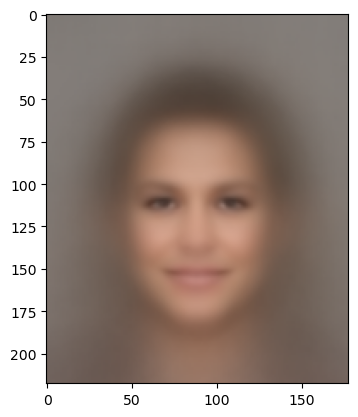

In [19]:
INPUT_PATH = os.path.join(os.getcwd(), 'images', "img_align_celeba")

aa = np.zeros((218, 178, 3))
for i in tqdm(glob.glob(os.path.join(INPUT_PATH, '*.jpg'))[:2500]):
    img = cv2.imread(i)
    aa += img
aaa = aa / 2500
plt.imshow(cv2.cvtColor(aaa.astype(np.float32), cv2.COLOR_BGR2RGB).astype(int))
plt.show()

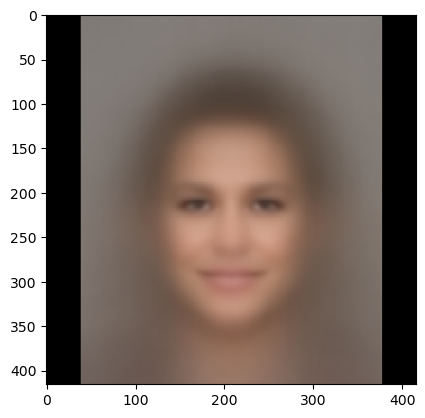

In [41]:
lala = np_to_tesor_img(aaa)
display_img(lala)

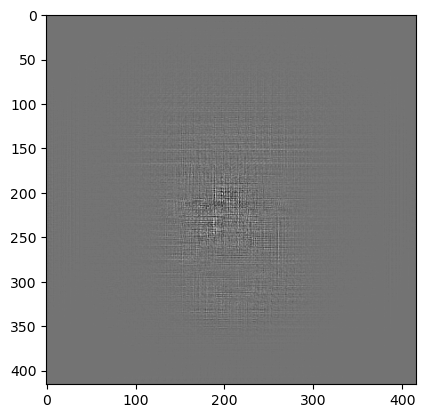

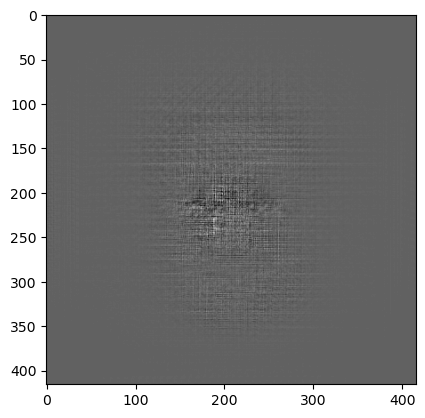

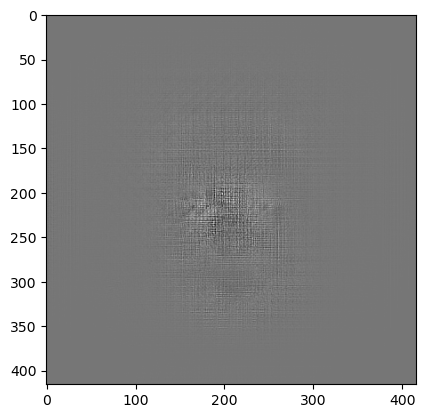

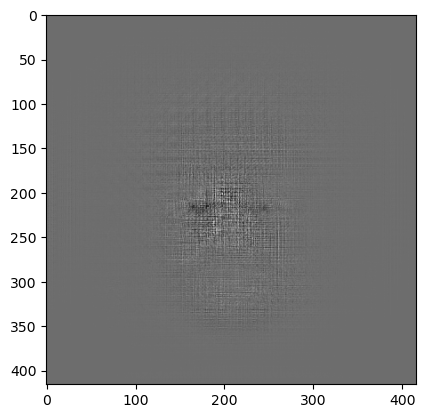

In [12]:
plt.imshow(torch.sum(torch.squeeze(combined_heatmap), dim=0), cmap='gray')
plt.show()
plt.imshow(torch.squeeze(combined_heatmap)[0], cmap='gray')
plt.show()
plt.imshow(torch.squeeze(combined_heatmap)[1], cmap='gray')
plt.show()
plt.imshow(torch.squeeze(combined_heatmap)[2], cmap='gray')
plt.show()

In [16]:
transformed_heatmap = torch.squeeze(combined_heatmap)
a_mean = torch.mean(transformed_heatmap)
color_mean = torch.mean(transformed_heatmap, dim=(1, 2))
transformed_heatmap = torch.square(transformed_heatmap - a_mean)
transformed_heatmap_r = torch.square(transformed_heatmap[0] - color_mean[0])
transformed_heatmap_g = torch.square(transformed_heatmap[1] - color_mean[1])
transformed_heatmap_b = torch.square(transformed_heatmap[2] - color_mean[2])

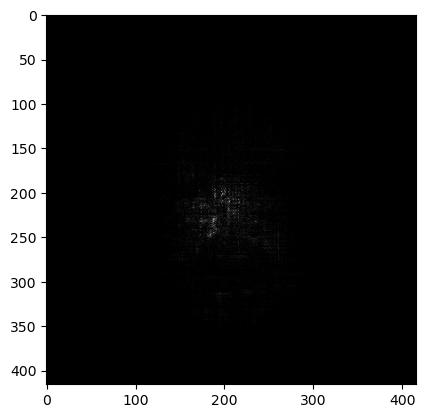

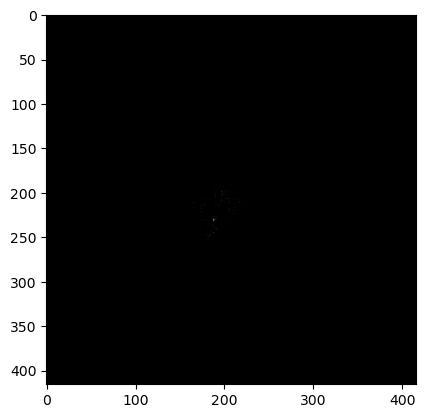

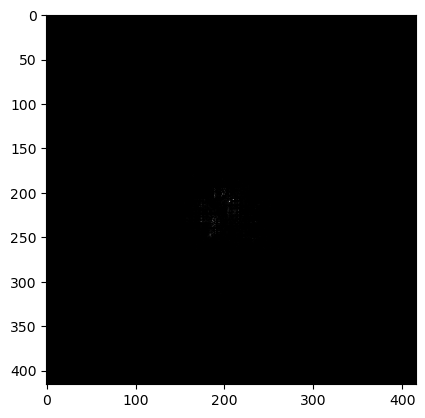

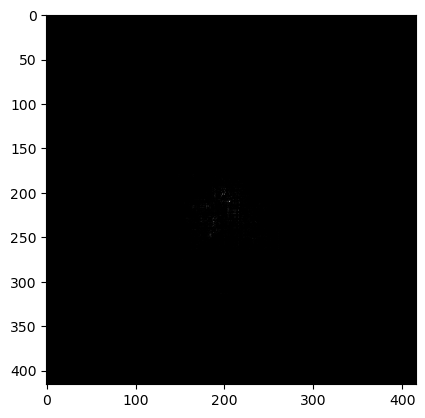

In [18]:
plt.imshow(torch.sum(torch.squeeze(transformed_heatmap), dim=0), cmap='gray')
plt.show()
plt.imshow(transformed_heatmap_r, cmap='gray')
plt.show()
plt.imshow(transformed_heatmap_g, cmap='gray')
plt.show()
plt.imshow(transformed_heatmap_b, cmap='gray')
plt.show()

In [15]:
# combined = cv2.imread(os.path.join(HEATMAP_PATH, "_combined_map.jpg"), 0)
# nosign = cv2.imread(os.path.join(HEATMAP_PATH, "_nosign_combined_map.jpg"), 0)
# tryh = cv2.imread(os.path.join(HEATMAP_PATH, "_try_combined_map.jpg"), 0)
# display_img(combined, nosign, tryh, cmap='gray')

##### ___